In [130]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

from sklearn.pipeline import Pipeline

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)


In [131]:
df = pd.read_csv("car data.csv")
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [132]:
# Размерность таблицы (число строк, столбцов)
df.shape


(4340, 8)

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


In [134]:
# Описательная статистика по числовым признакам
df.describe()


,year,selling_price,km_driven
count,4340.000000,4.340000e+03,4340.000000
mean,2013.090783,5.041273e+05,66215.777419
std,4.215344,5.785487e+05,46644.102194
min,1992.000000,2.000000e+04,1.000000
25%,2011.000000,2.087498e+05,35000.000000
50%,2014.000000,3.500000e+05,60000.000000
75%,2016.000000,6.000000e+05,90000.000000
max,2020.000000,8.900000e+06,806599.000000


In [135]:
# Описательная статистика по категориальным признакам
df.describe(include="object")


,name,fuel,seller_type,transmission,owner
count,4340,4340,4340,4340,4340
unique,1491,5,3,2,5
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner
freq,69,2153,3244,3892,2832


In [136]:
TARGET_COL = "selling_price"

y = df[TARGET_COL]

# В признаки не берём целевую переменную и name
X = df.drop(columns=[TARGET_COL, "name"])

X.head()


,year,km_driven,fuel,seller_type,transmission,owner
0,2007,70000,Petrol,Individual,Manual,First Owner
1,2007,50000,Petrol,Individual,Manual,First Owner
2,2012,100000,Diesel,Individual,Manual,First Owner
3,2017,46000,Petrol,Individual,Manual,First Owner
4,2014,141000,Diesel,Individual,Manual,Second Owner


In [137]:
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Числовые признаки:", numeric_cols)
print("Категориальные признаки:", categorical_cols)


Числовые признаки: ['year', 'km_driven']
Категориальные признаки: ['fuel', 'seller_type', 'transmission', 'owner']


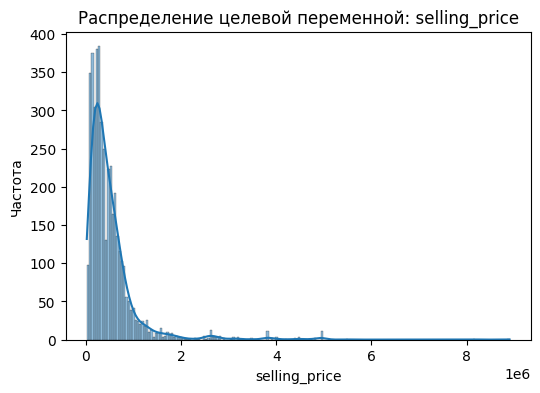

In [138]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Распределение целевой переменной: selling_price")
plt.xlabel("selling_price")
plt.ylabel("Частота")
plt.show()


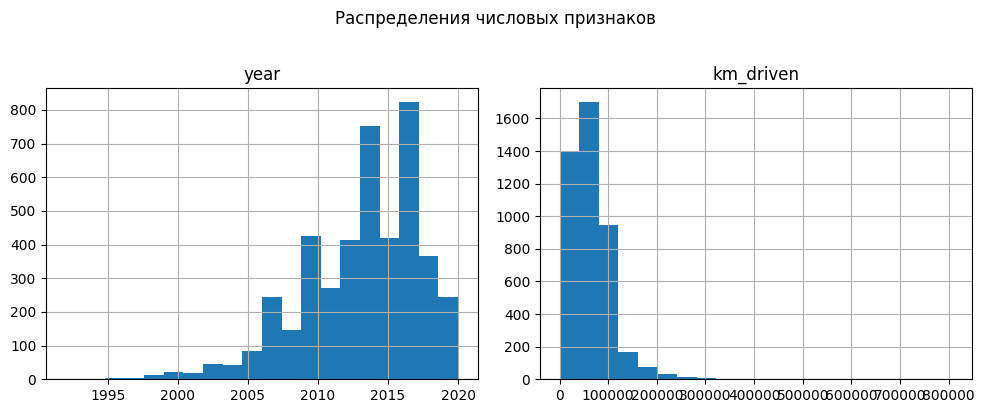

In [139]:
X[numeric_cols].hist(figsize=(10, 4), bins=20)
plt.suptitle("Распределения числовых признаков", y=1.02)
plt.tight_layout()
plt.show()


In [140]:
# Количество пропусков по столбцам
df.isna().sum()

name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
dtype: int64

In [141]:
df_clean = df.dropna().copy()
df_clean.shape

(4340, 8)

In [142]:
y = df_clean[TARGET_COL]

# Столбец name сохраняем в df_clean, но не берём в X
X = df_clean.drop(columns=[TARGET_COL, "name"])

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Числовые признаки:", numeric_cols)
print("Категориальные признаки:", categorical_cols)

Числовые признаки: ['year', 'km_driven']
Категориальные признаки: ['fuel', 'seller_type', 'transmission', 'owner']


In [143]:
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

X_encoded.head()

,year,km_driven,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,2007,70000,False,False,False,True,True,False,True,False,False,False,False
1,2007,50000,False,False,False,True,True,False,True,False,False,False,False
2,2012,100000,True,False,False,False,True,False,True,False,False,False,False
3,2017,46000,False,False,False,True,True,False,True,False,False,False,False
4,2014,141000,True,False,False,False,True,False,True,False,True,False,False


In [144]:
X_encoded.shape

(4340, 13)

In [145]:
# Собираем таблицу только для модели: целевая + закодированные признаки
df_model = pd.concat([y, X_encoded], axis=1)

# Корреляция целевой переменной со всеми признаками
target_corr = df_model.corr()["selling_price"].sort_values(ascending=False)
target_corr


selling_price                   1.000000
year                            0.413922
fuel_Diesel                     0.282947
seller_type_Trustmark Dealer    0.110176
owner_Test Drive Car            0.048799
fuel_Electric                  -0.005095
fuel_LPG                       -0.042434
owner_Fourth & Above Owner     -0.078725
owner_Third Owner              -0.111326
owner_Second Owner             -0.161986
km_driven                      -0.192289
seller_type_Individual         -0.236798
fuel_Petrol                    -0.269453
transmission_Manual            -0.530205
Name: selling_price, dtype: float64

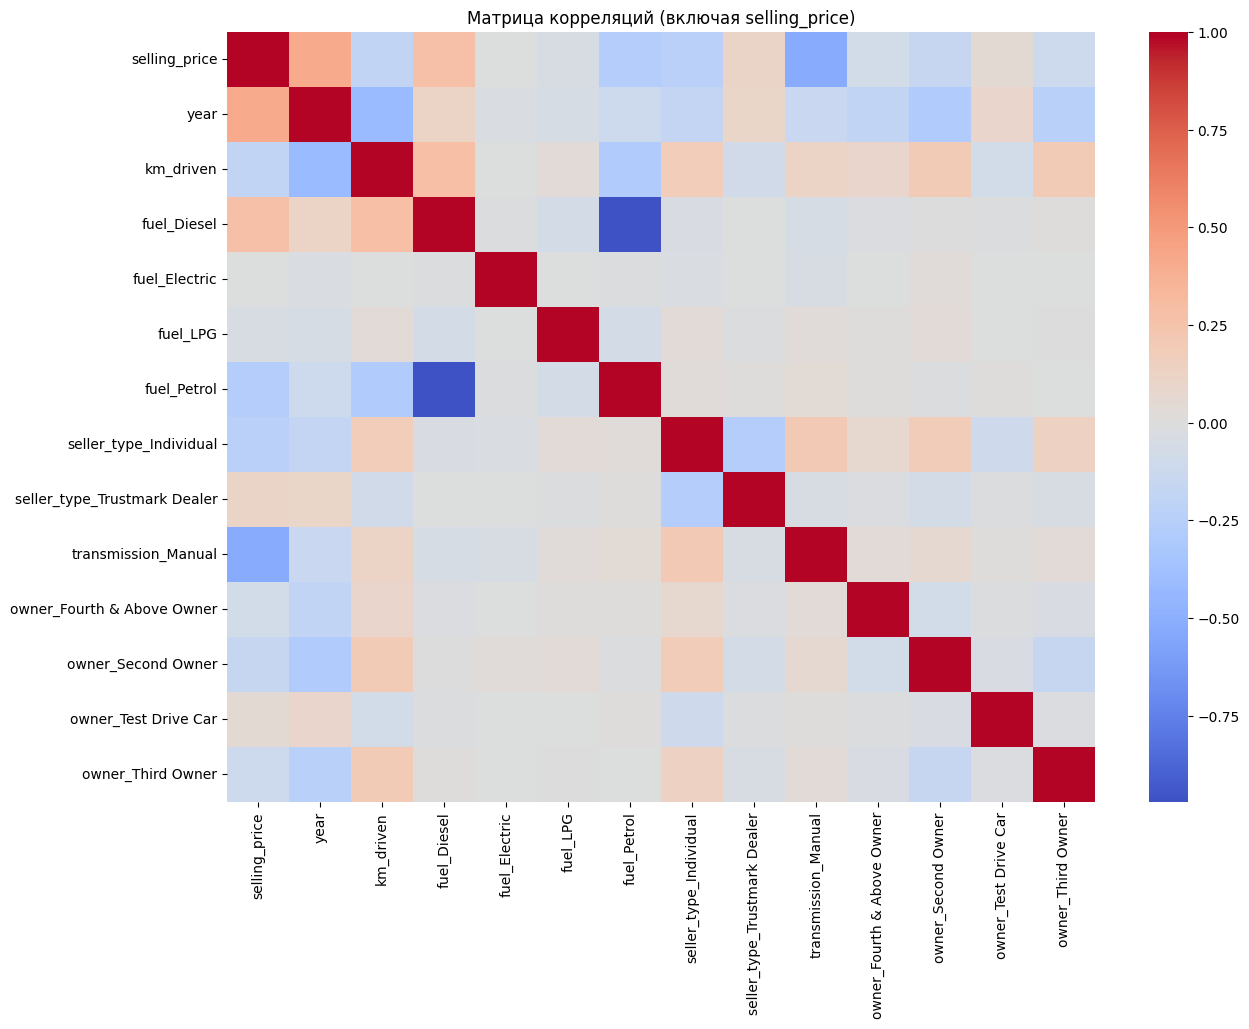

In [146]:
plt.figure(figsize=(14, 10))
corr_matrix = df_model.corr()

sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Матрица корреляций (включая selling_price)")
plt.show()

In [147]:
# Берём только числовые признаки
X_vif = X_encoded.copy()

# Приводим всё к float (на всякий случай)
X_vif = X_vif.astype(float)

# Если вдруг есть inf, заменим их на NaN, а NaN уберём
X_vif.replace([np.inf, -np.inf], np.nan, inplace=True)
X_vif.dropna(inplace=True)

# теперь считаем VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_vif.values, i)
    for i in range(X_vif.shape[1])
]

vif_data.sort_values(by="VIF", ascending=False)

,feature,VIF
0,year,121.220469
2,fuel_Diesel,55.103089
5,fuel_Petrol,54.148872
8,transmission_Manual,10.319791
6,seller_type_Individual,4.848329
1,km_driven,3.831143
4,fuel_LPG,1.576048
10,owner_Second Owner,1.542880
12,owner_Third Owner,1.207758
7,seller_type_Trustmark Dealer,1.108243


Высокие значения VIF у признаков year, fuel_Petrol, fuel_Diesel, transmission_Manual показывают, 
что эти переменные значительно коррелируют с другими признаками выборки и создают сильную мультиколлинеарность.

In [148]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42
)

X_train.shape, X_test.shape


((3472, 13), (868, 13))

In [149]:
lin_reg = LinearRegression()

# Обучаем на train
lin_reg.fit(X_train, y_train)

# Предсказание на test
y_pred_lin = lin_reg.predict(X_test)

# Метрики на тестовой выборке
mse_lin = mean_squared_error(y_test, y_pred_lin)
rmse_lin = mse_lin ** 0.5
r2_lin = r2_score(y_test, y_pred_lin)
mape_lin = mean_absolute_percentage_error(y_test, y_pred_lin) * 100  # в %

print("Линейная регрессия (test):")
print(f"  RMSE: {rmse_lin:.2f}")
print(f"  R²:   {r2_lin:.4f}")
print(f"  MAPE: {mape_lin:.2f}%")

Линейная регрессия (test):
  RMSE: 426786.69
  R²:   0.4031
  MAPE: 68.89%


In [150]:
cv = 5  # 5-fold cross-validation

# RMSE через neg_mean_squared_error
neg_mse_scores = cross_val_score(
    lin_reg, X_train, y_train,
    cv=cv,
    scoring='neg_mean_squared_error'
)
rmse_scores = (-neg_mse_scores) ** 0.5

# R^2
r2_scores = cross_val_score(
    lin_reg, X_train, y_train,
    cv=cv,
    scoring='r2'
)

# MAPE
neg_mape_scores = cross_val_score(
    lin_reg, X_train, y_train,
    cv=cv,
    scoring='neg_mean_absolute_percentage_error'
)
mape_scores = -neg_mape_scores * 100  # в %

print(f"\nЛинейная регрессия (CV, {cv}-fold):")
print(f"  RMSE по фолдам: {rmse_scores}")
print(f"  Средний RMSE:   {rmse_scores.mean():.2f}")
print(f"  Средний R²:     {r2_scores.mean():.4f}")
print(f"  Средний MAPE:   {mape_scores.mean():.2f}%")


Линейная регрессия (CV, 5-fold):
  RMSE по фолдам: [411540.61106726 403522.31758333 418177.34562305 414492.60466016
 482144.61630172]
  Средний RMSE:   425975.50
  Средний R²:     0.4681
  Средний MAPE:   71.68%


In [151]:

ridge_model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=10.0, random_state=42))
])

# Обучаем на train
ridge_model.fit(X_train, y_train)

# Предсказание на test
y_pred_ridge = ridge_model.predict(X_test)

# Метрики
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = mse_ridge ** 0.5
r2_ridge = r2_score(y_test, y_pred_ridge)
mape_ridge = mean_absolute_percentage_error(y_test, y_pred_ridge) * 100

print("Гребневая регрессия (test):")
print(f"  RMSE: {rmse_ridge:.2f}")
print(f"  R²:   {r2_ridge:.4f}")
print(f"  MAPE: {mape_ridge:.2f}%")

Гребневая регрессия (test):
  RMSE: 426724.64
  R²:   0.4033
  MAPE: 68.82%


In [152]:
cv = 5

neg_mse_scores_ridge = cross_val_score(
    ridge_model, X_train, y_train,
    cv=cv,
    scoring='neg_mean_squared_error'
)
rmse_scores_ridge = (-neg_mse_scores_ridge) ** 0.5

r2_scores_ridge = cross_val_score(
    ridge_model, X_train, y_train,
    cv=cv,
    scoring='r2'
)

neg_mape_scores_ridge = cross_val_score(
    ridge_model, X_train, y_train,
    cv=cv,
    scoring='neg_mean_absolute_percentage_error'
)
mape_scores_ridge = -neg_mape_scores_ridge * 100

print(f"\nГребневая регрессия (CV, {cv}-fold):")
print(f"  RMSE по фолдам: {rmse_scores_ridge}")
print(f"  Средний RMSE:   {rmse_scores_ridge.mean():.2f}")
print(f"  Средний R²:     {r2_scores_ridge.mean():.4f}")
print(f"  Средний MAPE:   {mape_scores_ridge.mean():.2f}%")



Гребневая регрессия (CV, 5-fold):
  RMSE по фолдам: [411641.82599332 403346.41376063 418258.90643589 414501.02319327
 482144.56834939]
  Средний RMSE:   425978.55
  Средний R²:     0.4681
  Средний MAPE:   71.52%


Для задачи прогнозирования цены автомобиля (`selling_price`) были построены модели
линейной регрессии и гребневой регрессии (Ridge). Данные были разделены на обучающую
и тестовую выборки в пропорции 80/20. Качество моделей оценивалось по метрикам
RMSE, R² и MAPE, а также с использованием 5-fold кросс-валидации.

Результаты для линейной регрессии:
- На тестовой выборке: RMSE ≈ 426 787, R² ≈ 0.403, MAPE ≈ 68.9%.
- По кросс-валидации: средний RMSE ≈ 425 976, средний R² ≈ 0.468, средний MAPE ≈ 71.7%.

Результаты для гребневой регрессии:
- На тестовой выборке: RMSE ≈ 426 725, R² ≈ 0.403, MAPE ≈ 68.8%.
- По кросс-валидации: средний RMSE ≈ 425 979, средний R² ≈ 0.468, средний MAPE ≈ 71.5%.

Видно, что обе модели показывают сопоставимое качество: значение R² порядка 0.4 означает,
что модель объясняет около 40 % вариации целевой переменной. Значения RMSE и MAPE
достаточно велики, что указывает на заметную погрешность прогнозов (средняя относительная
ошибка около 70 %).

In [153]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

X_scaled[:5]


array([[-1.44507431,  0.08113906, -0.99219635, -0.01518117, -0.0729916 ,
         1.02189871,  0.58125253, -0.15513851,  0.33927557, -0.13790776,
        -0.58480026, -0.06270928, -0.27444872],
       [-1.44507431, -0.3476891 , -0.99219635, -0.01518117, -0.0729916 ,
         1.02189871,  0.58125253, -0.15513851,  0.33927557, -0.13790776,
        -0.58480026, -0.06270928, -0.27444872],
       [-0.2587948 ,  0.7243813 ,  1.00786503, -0.01518117, -0.0729916 ,
        -0.97857057,  0.58125253, -0.15513851,  0.33927557, -0.13790776,
        -0.58480026, -0.06270928, -0.27444872],
       [ 0.92748471, -0.43345473, -0.99219635, -0.01518117, -0.0729916 ,
         1.02189871,  0.58125253, -0.15513851,  0.33927557, -0.13790776,
        -0.58480026, -0.06270928, -0.27444872],
       [ 0.215717  ,  1.60347903,  1.00786503, -0.01518117, -0.0729916 ,
        -0.97857057,  0.58125253, -0.15513851,  0.33927557, -0.13790776,
         1.70998557, -0.06270928, -0.27444872]])

In [154]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_scaled)


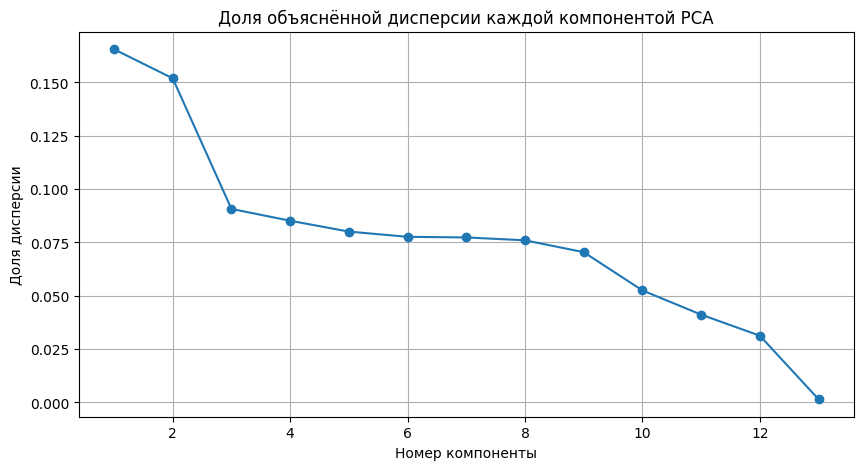

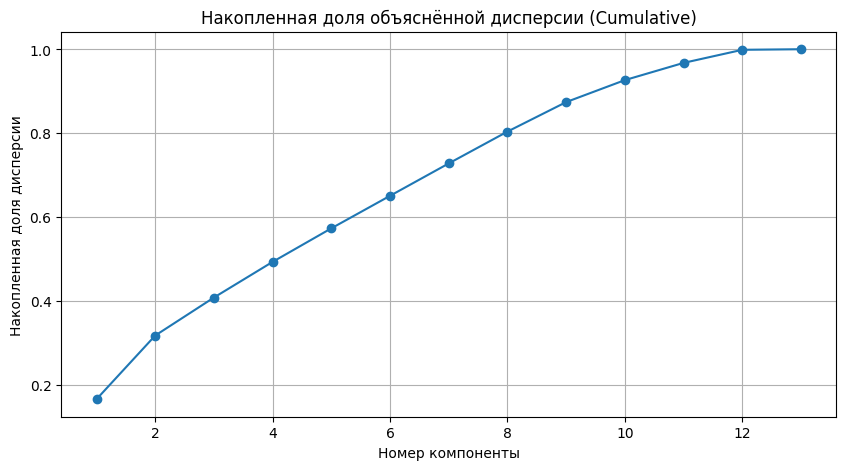

In [155]:
explained = pca.explained_variance_ratio_

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained) + 1), explained, marker='o')
plt.title("Доля объяснённой дисперсии каждой компонентой PCA")
plt.xlabel("Номер компоненты")
plt.ylabel("Доля дисперсии")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained) + 1), explained.cumsum(), marker='o')
plt.title("Накопленная доля объяснённой дисперсии (Cumulative)")
plt.xlabel("Номер компоненты")
plt.ylabel("Накопленная доля дисперсии")
plt.grid(True)
plt.show()


In [156]:
import numpy as np

cum = np.cumsum(explained)
k_90 = np.argmax(cum >= 0.90) + 1
k_95 = np.argmax(cum >= 0.95) + 1

print(f"Количество компонент для 90% дисперсии: {k_90}")
print(f"Количество компонент для 95% дисперсии: {k_95}")


Количество компонент для 90% дисперсии: 10
Количество компонент для 95% дисперсии: 11


In [157]:
pca_final = PCA(n_components=k_95)
X_pca_final = pca_final.fit_transform(X_scaled)

X_pca_final.shape


(4340, 11)

После стандартизации признаков был применён метод главных компонент (PCA).
В результате были получены 13 главных компонент (по числу исходных признаков).

График долей объяснённой дисперсии показал, что:
- первая компонента объясняет около 16 % дисперсии данных,
- вторая — около 15 %,
- каждая из последующих компонент добавляет всё меньший вклад.

Анализ накопленной доли дисперсии показал, что:
- первые 10 компонент объясняют примерно 90 % общей вариации данных,
- первые 11 компонент — около 95 %.

Таким образом, для дальнейшего анализа было выбрано 11 главных компонент,
что позволило снизить размерность признакового пространства с 13 до 11
при сохранении порядка 95 % информации.

In [158]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca_final, y, test_size=0.2, random_state=42
)

X_train_pca.shape, X_test_pca.shape

((3472, 11), (868, 11))

In [159]:
lin_pca = LinearRegression()
lin_pca.fit(X_train_pca, y_train_pca)

y_pred_lin_pca = lin_pca.predict(X_test_pca)

mse_lin_pca = mean_squared_error(y_test_pca, y_pred_lin_pca)
rmse_lin_pca = mse_lin_pca ** 0.5
r2_lin_pca = r2_score(y_test_pca, y_pred_lin_pca)
mape_lin_pca = mean_absolute_percentage_error(y_test_pca, y_pred_lin_pca) * 100

print("Линейная регрессия на PCA (test):")
print(f"  RMSE: {rmse_lin_pca:.2f}")
print(f"  R²:   {r2_lin_pca:.4f}")
print(f"  MAPE: {mape_lin_pca:.2f}%")


Линейная регрессия на PCA (test):
  RMSE: 427423.00
  R²:   0.4013
  MAPE: 67.65%


In [160]:
cv = 5

neg_mse_scores_lin_pca = cross_val_score(
    lin_pca, X_train_pca, y_train_pca,
    cv=cv,
    scoring="neg_mean_squared_error"
)
rmse_scores_lin_pca = (-neg_mse_scores_lin_pca) ** 0.5

r2_scores_lin_pca = cross_val_score(
    lin_pca, X_train_pca, y_train_pca,
    cv=cv,
    scoring="r2"
)

neg_mape_scores_lin_pca = cross_val_score(
    lin_pca, X_train_pca, y_train_pca,
    cv=cv,
    scoring="neg_mean_absolute_percentage_error"
)
mape_scores_lin_pca = -neg_mape_scores_lin_pca * 100

print(f"\nЛинейная регрессия на PCA (CV, {cv}-fold):")
print(f"  RMSE по фолдам: {rmse_scores_lin_pca}")
print(f"  Средний RMSE:   {rmse_scores_lin_pca.mean():.2f}")
print(f"  Средний R²:     {r2_scores_lin_pca.mean():.4f}")
print(f"  Средний MAPE:   {mape_scores_lin_pca.mean():.2f}%")



Линейная регрессия на PCA (CV, 5-fold):
  RMSE по фолдам: [8946191.32142101  403896.53007176  418512.80444072  416632.38432208
  482657.08471837]
  Средний RMSE:   2133578.02
  Средний R²:     -46.3579
  Средний MAPE:   91.99%


In [161]:
ridge_pca = Ridge(alpha=10.0, random_state=42)
ridge_pca.fit(X_train_pca, y_train_pca)

y_pred_ridge_pca = ridge_pca.predict(X_test_pca)

mse_ridge_pca = mean_squared_error(y_test_pca, y_pred_ridge_pca)
rmse_ridge_pca = mse_ridge_pca ** 0.5
r2_ridge_pca = r2_score(y_test_pca, y_pred_ridge_pca)
mape_ridge_pca = mean_absolute_percentage_error(y_test_pca, y_pred_ridge_pca) * 100

print("Гребневая регрессия на PCA (test):")
print(f"  RMSE: {rmse_ridge_pca:.2f}")
print(f"  R²:   {r2_ridge_pca:.4f}")
print(f"  MAPE: {mape_ridge_pca:.2f}%")


Гребневая регрессия на PCA (test):
  RMSE: 427344.79
  R²:   0.4016
  MAPE: 67.58%


In [162]:
neg_mse_scores_ridge_pca = cross_val_score(
    ridge_pca, X_train_pca, y_train_pca,
    cv=cv,
    scoring="neg_mean_squared_error"
)
rmse_scores_ridge_pca = (-neg_mse_scores_ridge_pca) ** 0.5

r2_scores_ridge_pca = cross_val_score(
    ridge_pca, X_train_pca, y_train_pca,
    cv=cv,
    scoring="r2"
)

neg_mape_scores_ridge_pca = cross_val_score(
    ridge_pca, X_train_pca, y_train_pca,
    cv=cv,
    scoring="neg_mean_absolute_percentage_error"
)
mape_scores_ridge_pca = -neg_mape_scores_ridge_pca * 100

print(f"\nГребневая регрессия на PCA (CV, {cv}-fold):")
print(f"  RMSE по фолдам: {rmse_scores_ridge_pca}")
print(f"  Средний RMSE:   {rmse_scores_ridge_pca.mean():.2f}")
print(f"  Средний R²:     {r2_scores_ridge_pca.mean():.4f}")
print(f"  Средний MAPE:   {mape_scores_ridge_pca.mean():.2f}%")



Гребневая регрессия на PCA (CV, 5-fold):
  RMSE по фолдам: [427682.65902581 403743.37812472 418580.62235315 416601.12845805
 482671.40538544]
  Средний RMSE:   429855.84
  Средний R²:     0.4585
  Средний MAPE:   70.30%
